# Example 7-3

K-Means featurizer

In [1]:
import numpy as np

In [2]:
from sklearn.cluster import KMeans

In [3]:
class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.

    Parameters
    ----------
    k: integer, optional, default 100
        The number of clusters to group data into.

    target_scale: float, [0, infty], optional, default 5.0
        The scaling factor for the target variable. Set this to zero to ignore
        the target. For classification problems, larger `target_scale` values 
        will produce clusters that better respect the class boundary.

    random_state : integer or numpy.RandomState, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.
    
    **kwargs : dict
        Additional KMeans parameters

    Attributes
    ----------
    cluster_centers_ : array, [k, n_features]
        Coordinates of cluster centers. n_features does count the target column.
    """

    def __init__(self, k=100, target_scale=5.0, random_state=None, **kwargs):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.kwargs = kwargs
        
    def fit(self, X, y=None):
        """Runs k-means on the input data and find centroids.

        If no target is given (`y` is None) then run vanilla k-means on input
        `X`. 

        If target `y` is given, then include the target (weighted by 
        `target_scale`) as an extra dimension for k-means clustering. In this 
        case, run k-means twice, first with the target, then an extra iteration
        without.

        After fitting, the attribute `cluster_centers_` are set to the k-means
        centroids in the input space represented by `X`.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            If provided, will be weighted with `target_scale` and included in 
            k-means clustering as hint.
        """
        
        if y is None:
            # No target variable, just do plain k-means
            km_model = KMeans(n_clusters=self.k, 
                              n_init=20, 
                              random_state=self.random_state,
                              **self.kwargs)
            km_model.fit(X)

            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # There is target information. Apply appropriate scaling and include
        # into input data to k-means            
        data_with_target = np.hstack((X, y[:, np.newaxis] * self.target_scale))

        # Build a pre-training k-means model on data and target
        km_model_pretrain = KMeans(n_clusters=self.k, 
                                   n_init=20, 
                                   random_state=self.random_state,
                                   **self.kwargs)
        km_model_pretrain.fit(data_with_target)

        # Run k-means a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training.
        # Go through a single iteration of cluster assignment and centroid 
        # recomputation.
        km_model = KMeans(n_clusters=self.k, 
                          init=km_model_pretrain.cluster_centers_[:, :-1], 
                          n_init=1, 
                          max_iter=1,
                          **self.kwargs)
        km_model.fit(X)
        
        self.km_model_ = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        """Outputs the closest cluster id for each input data point.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            Target vector is ignored even if provided.

        Returns
        -------
        cluster_ids : array, shape[n_data_points, 1]
        """
        return self.km_model_.predict(X)[:, np.newaxis]
    
    def fit_transform(self, X, y=None):
        """Runs fit followed by transform."""
        return self.fit(X, y).transform(X, y)

# Example 7-4

K-Means featurization with and without target hints

In [4]:
import matplotlib.pyplot as plt

In [5]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.datasets import make_moons

In [6]:
seed = 1
training_data, training_labels = make_moons(n_samples=2000, noise=0.2, random_state=seed)

In [7]:
kmf_hint = (KMeansFeaturizer(k=100, 
                             target_scale=10, 
                             random_state=seed, 
                             n_jobs=-1)
            .fit(training_data, training_labels))
kmf_no_hint = (KMeansFeaturizer(k=100, 
                                target_scale=0, 
                                random_state=seed, 
                                n_jobs=-1)
               .fit(training_data, training_labels))

In [8]:
def kmeans_voronoi_plot(X, y, cluster_centers, ax):
    """Plots the Voronoi diagram of the kmeans clusters overlayed with the data"""
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', alpha=0.2)
    vor = Voronoi(cluster_centers)
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, alpha=0.5)

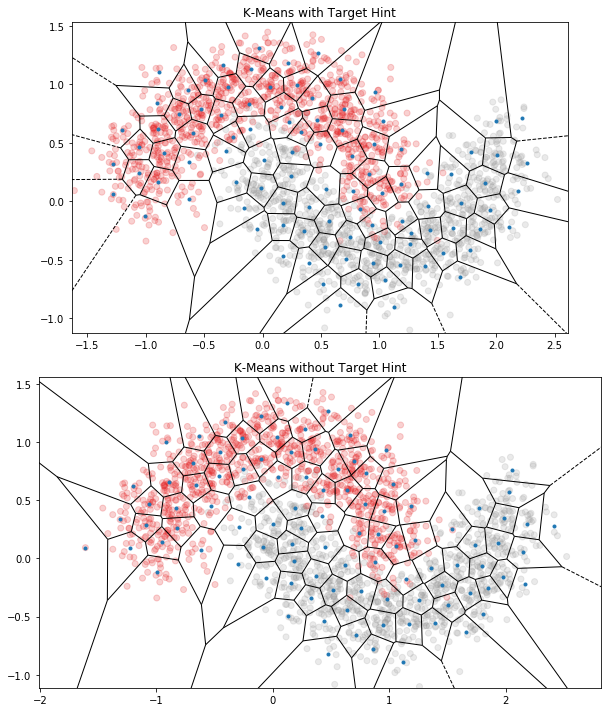

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))

kmeans_voronoi_plot(training_data, training_labels, kmf_hint.cluster_centers_, ax1)
ax1.set_aspect('equal')
ax1.set_title('K-Means with Target Hint')

kmeans_voronoi_plot(training_data, training_labels, kmf_no_hint.cluster_centers_, ax2)
ax2.set_aspect('equal')
ax2.set_title('K-Means without Target Hint')

plt.tight_layout()
plt.show()

# Example 7-5

Classification with K-Means clustering features

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier)
from sklearn.metrics import roc_curve
from sklearn.pipeline import (make_union, 
                              make_pipeline)
from sklearn.preprocessing import (FunctionTransformer, 
                                   OneHotEncoder)

In [11]:
# Generate some test data from the same distribution as training data
test_data, test_labels = make_moons(n_samples=2000, noise=0.3, random_state=seed+5)

In [12]:
# Create a data pipeline (original features + cluster ohe)
data_pipeline = make_union(
    FunctionTransformer(lambda X: X), 
    make_pipeline(kmf_hint, 
                  OneHotEncoder())
)

In [13]:
# Use the k-means featurizer to generate cluster features
training_with_cluster = data_pipeline.fit_transform(training_data, training_labels)
test_with_cluster = data_pipeline.transform(test_data)

In [14]:
# Build the classifiers
lr_cluster = (LogisticRegression(random_state=seed)
              .fit(training_with_cluster, training_labels))

classifier_names = ['LR',
                    'kNN',
                    'RBF SVM',
                    'Random Forest',
                    'Boosted Trees']
classifiers = [LogisticRegression(random_state=seed),
               KNeighborsClassifier(5),
               SVC(gamma=2, C=1, random_state=seed),
               RandomForestClassifier(max_depth=5, n_estimators=10, 
                                      max_features=1, random_state=seed),
               GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
                                          max_depth=5, random_state=seed)]
for model in classifiers:
    model.fit(training_data, training_labels)

In [15]:
# Helper function to evaluate classifier performance using ROC
def test_roc(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    fpr, tpr, _ = roc_curve(labels, predictions)
    return fpr, tpr

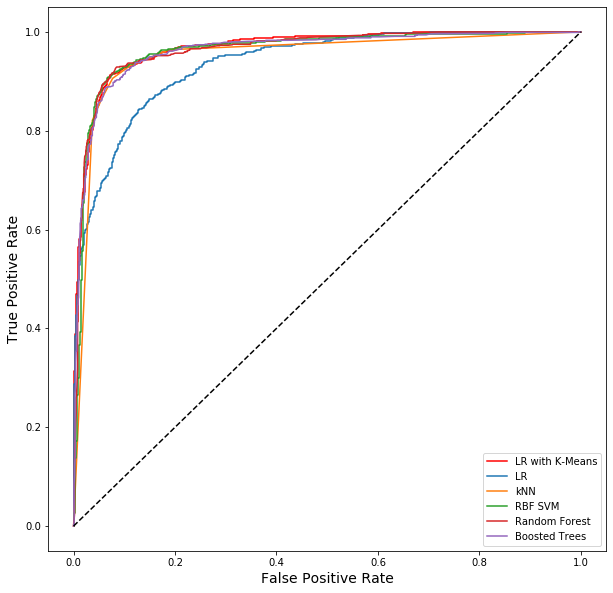

In [16]:
plt.figure(figsize=(10, 10))

# Logistic Regression with cluster features
fpr_cluster, tpr_cluster = test_roc(lr_cluster, test_with_cluster, test_labels)
plt.plot(fpr_cluster, tpr_cluster, 'r-', label='LR with K-Means')

# Other classifiers without cluster features
for i, model in enumerate(classifiers):
    fpr, tpr = test_roc(model, test_data, test_labels)
    plt.plot(fpr, tpr, label=classifier_names[i])

# Random guess
plt.plot([0, 1], [0, 1], 'k--')

plt.legend()
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

plt.show()